In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import colorlover as cl
colors = [[i / 255 for i in j] for j in cl.to_numeric(cl.scales['5']['qual']['Dark2'])]

In [25]:
county_shapes = pd.read_csv("./ny_county_shapes.csv").set_index("county_name")
ny_map_county_shapes = pd.read_csv("./ny_map_county_squares.csv")

In [26]:
def ny_scatter2(ax, df, coord_col_name = "test_{}_rank"):
    # fig, ax = plt.subplots(figsize = (s, s))
    for ind, county in enumerate(df.county_name.unique()):
        county_df = df[df.county_name == county]
        ax.scatter(
            y = county_df[coord_col_name.format("lat")],
            x = county_df[coord_col_name.format("lng")],
            s = county_df.sqrt_mult / 2,
            marker = "s",
            label = county,
            alpha = 0.7,
            color = colors[ind % 5],
            edgecolor = "none")
    # ax.legend(loc = 9, bbox_to_anchor = (0.5,0))
    # return fig

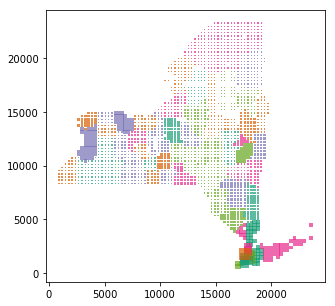

In [27]:
fig, ax = plt.subplots(figsize = (5, 5))
ny_scatter2(ax, ny_map_county_shapes)

In [28]:
for i in ["lat", "lng"]:
    ny_map_county_shapes["new_scaled_{}_rank".format(i)] = ny_map_county_shapes["test_{}_rank".format(i)]

In [29]:
ny_map_county_shapes["square_id"] = ny_map_county_shapes.index

In [30]:
def dist(x1, y1, x2, y2):
    return np.sqrt(np.power(x1 - x2, 2) + np.power(y1 - y2, 2))

In [104]:
def check_intersect(row):
    return (min(
        [row["scaled_min_{}_rank_{}".format(i, j[0])] <= row["scaled_max_{}_rank_{}".format(i, j[1])]
        for i in ["lng", "lat"] for j in rev_pair(["x", "y"])]))

def compress(ny_map_county_shapes):
    ny_map_county_shapes["dummy"] = 1
    select_cols = ["square_id", "dummy"] + ["new_scaled_{}_rank".format(i) for i in ["lat", "lng"]]
    ny_map_county_square_pairs = ny_map_county_shapes[select_cols].merge(right = ny_map_county_shapes[select_cols], on = "dummy", how = "left")
    ny_map_county_square_pairs = ny_map_county_square_pairs[~(ny_map_county_square_pairs.square_id_x == ny_map_county_square_pairs.square_id_y)]
    
    d = dist(*[ny_map_county_square_pairs["new_scaled_{}_rank_{}".format(j, i)] for i in ["x", "y"] for j in ["lat", "lng"]])
    min_d = d.min()
    max_d = d.max()
    a = - 0.001 / ((min_d - max_d) ** 2)
    d_factor = a * (min_d - d) * (max_d - d)
    
    for i in ["lat", "lng"]:
        ny_map_county_square_pairs["force_{}".format(i)] = (d_factor * 
            (ny_map_county_square_pairs["new_scaled_{}_rank_y".format(i)] - ny_map_county_square_pairs["new_scaled_{}_rank_x".format(i)]))
        
    sum_forces = ny_map_county_square_pairs.groupby(["square_id_x"], as_index = False).agg({"force_{}".format(i): "sum" for i in ["lat", "lng"]})
    
    ny_map_county_shapes = ny_map_county_shapes.merge(
        right = sum_forces,
        left_on = ["square_id"],
        right_on = ["square_id_x"],
        how = "left")
    
    for i in ["lat", "lng"]:
        ny_map_county_shapes["new_scaled_{}_rank".format(i)] = (ny_map_county_shapes["new_scaled_{}_rank".format(i)] +
            ny_map_county_shapes["force_{}".format(i)])
    
    return ny_map_county_shapes.drop(columns = ["force_{}".format(i) for i in ["lat", "lng"]])

In [105]:
niter = 10

In [ ]:
prev = ny_map_county_shapes
test_dfs = []

for i in tqdm(range(niter)):
    test_dfs.append(compress(prev))
    prev = test_dfs[-1]

 10%|█         | 1/10 [00:02<00:25,  2.85s/it]

In [ ]:
fig, ax = plt.subplots(figsize = (5, niter * 5), nrows = niter + 1)#, sharey = True, sharex = True)
ny_scatter2(ax[0], ny_map_county_shapes)
for i in range(niter):
    ny_scatter2(ax[i + 1], test_dfs[i], coord_col_name = "new_scaled_{}_rank")